# 0. Install stuffs

In [1]:
import os, sys
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
from shared_functions.global_functions import *

In [3]:
text = get_text_from_s3('nghi_dinh_duan_ap_dung_cac_loai_hopdong.pdf')

# 1.2 Get metadata

In [4]:
def extract_metadata(text):
    """
    Extract metadata from decree document

    Parameters:
        text (str): Raw text from read_doc_file()

    Returns:
        dict: Dictionary containing metadata
            - decree_number: Số nghị định (e.g., "07/VBHN-BTC")
            - date: Ngày ban hành
            - title: Tên nghị định (all caps text after NGHỊ ĐỊNH)
            - ministry: Bộ ban hành (e.g., "BỘ TÀI CHÍNH")
    """
    import re

    metadata = {
        'decree_number': None,
        'date': None,
        'title': None,
        'ministry': None
    }

    # Extract decree number (Số: XX/XXXX/NĐ-CP or Số: XX/VBHN-XXX)
    decree_pattern = r'Số:\s*([^\s]+)'
    decree_match = re.search(decree_pattern, text)
    if decree_match:
        metadata['decree_number'] = decree_match.group(1).strip()

    # Extract date (Hà Nội, ngày XX tháng XX năm XXXX)
    date_pattern = r'Hà Nội,\s*ngày\s+(\d+)\s+tháng\s+(\d+)\s+năm\s+(\d+)'
    date_match = re.search(date_pattern, text)
    if date_match:
        day = date_match.group(1)
        month = date_match.group(2)
        year = date_match.group(3)
        metadata['date'] = f"{day}/{month}/{year}"

    # Extract ministry (BỘ ... or CHÍNH PHỦ)
    ministry_pattern = r'(BỘ\s+[A-ZÀÁẢÃẠĂẮẰẲẴẶÂẤẦẨẪẬĐÈÉẺẼẸÊẾỀỂỄỆÌÍỈĨỊÒÓỎÕỌÔỐỒỔỖỘƠỚỜỞỠỢÙÚỦŨỤƯỨỪỬỮỰỲÝỶỸỴ\s]+)(?=\s*\||\s*CỘNG HÒA|\s*-------)'
    ministry_match = re.search(ministry_pattern, text)
    if not ministry_match:
        ministry_pattern = r'(CHÍNH PHỦ)'
        ministry_match = re.search(ministry_pattern, text)
    if ministry_match:
        metadata['ministry'] = ministry_match.group(1).strip()

    # Extract title (all caps text after NGHỊ ĐỊNH)
    title_pattern = r'NGHỊ ĐỊNH[^\n]*\n([A-ZÀÁẢÃẠĂẮẰẲẴẶÂẤẦẨẪẬĐÈÉẺẼẸÊẾỀỂỄỆÌÍỈĨỊÒÓỎÕỌÔỐỒỔỖỘƠỚỜỞỠỢÙÚỦŨỤƯỨỪỬỮỰỲÝỶỸỴ\s,]+?)(?=\n[^A-ZÀÁẢÃẠĂẮẰẲẴẶÂẤẦẨẪẬĐÈÉẺẼẸÊẾỀỂỄỆÌÍỈĨỊÒÓỎÕỌÔỐỒỔỖỘƠỚỜỞỠỢÙÚỦŨỤƯỨỪỬỮỰỲÝỶỸỴ]|\nCăn cứ|\nĐiều)'
    title_match = re.search(title_pattern, text, re.MULTILINE)
    if title_match:
        metadata['title'] = title_match.group(1).strip()

    return metadata

In [5]:
# Extract metadata
metadata = extract_metadata(text)

# Print results
print("=== EXTRACTED METADATA ===")
print(f"Ministry: {metadata['ministry']}")
print(f"Decree Number: {metadata['decree_number']}")
print(f"Date: {metadata['date']}")
print(f"Title: {metadata['title']}")
## Expected Output (based on your document)
# === EXTRACTED METADATA ===
# Ministry: BỘ TÀI CHÍNH
# Decree Number: 07/VBHN-BTC
# Date: 22/4/2025
# Title: BIỂU THUẾ XUẤT KHẨU, BIỂU THUẾ NHẬP KHẨU ƯU ĐÃI...

=== EXTRACTED METADATA ===
Ministry: CHÍNH PHỦ
Decree Number: 256/2025/NĐ-CP
Date: 03/10/2025
Title: None


### 1.2.1 Get articles

In [6]:
def extract_articles(text):
    """
    Extract all articles from decree document

    Parameters:
        text (str): Raw text from read_doc_file()

    Returns:
        list: List of dictionaries, each containing:
            - article_number: e.g., "Điều 1"
            - article_title: Title of the article
            - content: Full text content of the article (including clauses)
    """
    import re

    articles = []

    # Pattern to find articles: "Điều [number]. [Title]"
    # This pattern captures: Điều 1. or Điều 10. etc.
    article_pattern = r'(Điều\s+\d+)\.\s*([^\n]+)'

    # Find all article headers
    article_matches = list(re.finditer(article_pattern, text))

    if not article_matches:
        print("⚠ No articles found")
        return articles

    print(f"✓ Found {len(article_matches)} articles")

    # Extract content for each article
    for i, match in enumerate(article_matches):
        article_number = match.group(1).strip()  # e.g., "Điều 1"
        article_title = match.group(2).strip()   # e.g., "Phạm vi điều chỉnh"

        # Get start position of this article
        start_pos = match.start()

        # Get end position (start of next article, or end of document)
        if i + 1 < len(article_matches):
            end_pos = article_matches[i + 1].start()
        else:
            end_pos = len(text)

        # Extract full content including the article header
        full_content = text[start_pos:end_pos].strip()

        articles.append({
            'article_number': article_number,
            'article_title': article_title,
            'content': full_content
        })

    return articles

In [7]:
# Extract articles
articles = extract_articles(text)


✓ Found 33 articles


In [48]:
for article in articles:
    print(article['content'])
    print('-'*50)

Điều 1. Phạm vi điều chỉnh
1. Nghị định này quy định chi tiết một số điều của Luật Đầu tư theo phương thức đối tác công tư về 
việc thực hiện dự án áp dụng loại hợp đồng Xây dựng - Chuyển giao (dự án BT), gồm:
a) Điều 11 về quy trình thực hiện dự án BT;
b) Điều 42 về phương pháp và tiêu chuẩn đánh giá hồ sơ dự thầu;
c) Điểm a khoản 2a Điều 45 về dự án BT thanh toán bằng quỹ đất;
d) Điểm b khoản 2a Điều 45 về dự án BT thanh toán bằng ngân sách nhà nước.
2. Nghị định này không áp dụng đối với dự án BT không yêu cầu thanh toán quy định tại điểm c khoản 
2a Điều 45 của Luật Đầu tư theo phương thức đối tác công tư.
3. Cơ chế quản lý tài chính dự án, lãi vay sau thời gian xây dựng đối với dự án BT thanh toán bằng quỹ 
đất thực hiện theo quy định của Chính phủ quy định cơ chế quản lý tài chính dự án đầu tư theo phương 
thức đối tác công tư và cơ chế thanh toán, quyết toán đối với dự án áp dụng loại hợp đồng BT.
--------------------------------------------------
Điều 2. Đối tượng áp dụng
Nghị 

In [8]:
length = []
for article in articles:
    length.append(len(article['content'].split()))

<Axes: ylabel='Count'>

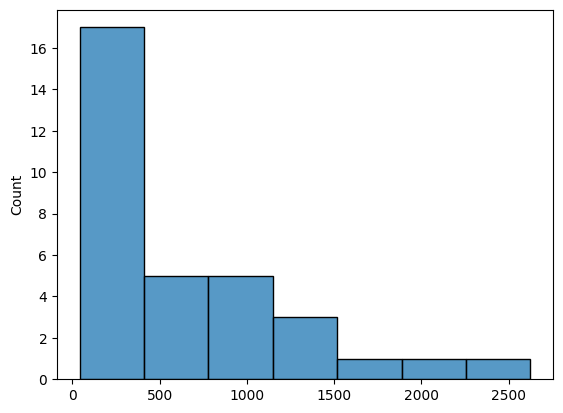

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(length)

### 1.2.2 Parse Clauses ( extract the numbered structure)

In [10]:
def parse_clauses(article_content):
    """
    Parse clauses from article content

    Parameters:
        article_content (str): Full content of an article

    Returns:
        list: List of dictionaries with clause structure:
            - clause_number: e.g., "1", "2", "a", "b", "đ"
            - clause_type: "main" for 1,2,3 or "sub" for a,b,c,đ
            - content: Text content of the clause
    """
    import re

    clauses = []

    # Pattern for main clauses: "1." "2." "3." at start of line
    main_clause_pattern = r'^(\d+)\.\s+(.+?)(?=^\d+\.|^[a-z]đ?\)|$)'

    # Pattern for sub-clauses: "a)" "b)" "c)" "d)" "đ)" "e)" at start of line
    sub_clause_pattern = r'^([a-zđ])\)\s+(.+?)(?=^[a-zđ]\)|^\d+\.|$)'

    # Find main clauses
    main_matches = re.finditer(main_clause_pattern, article_content, re.MULTILINE | re.DOTALL)

    for match in main_matches:
        clause_num = match.group(1)
        clause_content = match.group(2).strip()

        clauses.append({
            'clause_number': clause_num,
            'clause_type': 'main',
            'content': clause_content
        })

    # Find sub-clauses
    sub_matches = re.finditer(sub_clause_pattern, article_content, re.MULTILINE | re.DOTALL)

    for match in sub_matches:
        clause_letter = match.group(1)
        clause_content = match.group(2).strip()

        clauses.append({
            'clause_number': clause_letter,
            'clause_type': 'sub',
            'content': clause_content
        })

    # Sort clauses by their appearance in text
    clauses.sort(key=lambda x: article_content.find(x['content']))

    return clauses

In [11]:
# Test with Điều 2 (has numbered clauses: 1, 2, 3)
article_2 = articles[1]  # Điều 2

print(f"=== Testing: {article_2['article_number']} ===")
print(f"Title: {article_2['article_title']}\n")

clauses = parse_clauses(article_2['content'])

print(f"Found {len(clauses)} clauses:\n")
for clause in clauses:
    print(f"[{clause['clause_type'].upper()}] {clause['clause_number']}")
    print(f"Content: {clause['content'][:100]}...")
    print()

=== Testing: Điều 2 ===
Title: Đối tượng áp dụng

Found 0 clauses:



In [ ]:
for chunk in chunks:
    print(chunk['text'])

[{'chunk_id': '256_2025_NĐ_CP_chunk_0001',
  'text': 'Điều 1. Phạm vi điều chỉnh',
  'metadata': {'decree_number': '256/2025/NĐ-CP',
   'decree_date': '03/10/2025',
   'decree_title': None,
   'article_number': 'Điều 1',
   'article_title': 'Phạm vi điều chỉnh',
   'clause_number': 'header',
   'chunk_type': 'article_header',
   'is_complex': False}},
 {'chunk_id': '256_2025_NĐ_CP_chunk_0002',
  'text': '1. Nghị\xa0định\xa0này\xa0quy\xa0định\xa0chi\xa0tiết\xa0một\xa0số\xa0điều\xa0của\xa0Luật\xa0Đầu\xa0tư\xa0theo\xa0phương\xa0thức\xa0đối\xa0tác\xa0công\xa0tư\xa0về\xa0\nviệc\xa0thực\xa0hiện\xa0dự\xa0án\xa0áp\xa0dụng\xa0loại\xa0hợp\xa0đồng\xa0Xây\xa0dựng\xa0-\xa0Chuyển\xa0giao\xa0(dự\xa0án\xa0BT),\xa0gồm:',
  'metadata': {'decree_number': '256/2025/NĐ-CP',
   'decree_date': '03/10/2025',
   'decree_title': None,
   'article_number': 'Điều 1',
   'article_title': 'Phạm vi điều chỉnh',
   'clause_number': '1',
   'chunk_type': 'main_clause_intro',
   'is_complex': False}},
 {'chunk_id': '25

In [12]:
# Test with an article that has sub-clauses
# Let's check Điều 3 or find one with a), b), đ)

# First, let's see which article has sub-clauses
print("=== Searching for articles with sub-clauses ===\n")

for i, article in enumerate(articles[:5]):  # Check first 5
    if 'a)' in article['content'] or 'đ)' in article['content']:
        print(f"Found sub-clauses in: {article['article_number']}")
        print(f"Title: {article['article_title']}\n")

        # Test parsing
        clauses = parse_clauses(article['content'])
        print(f"Total clauses: {len(clauses)}\n")

        for clause in clauses:
            print(f"[{clause['clause_type'].upper()}] {clause['clause_number']}")
            print(f"Content: {clause['content'][:80]}...")
            print()

        break

=== Searching for articles with sub-clauses ===

Found sub-clauses in: Điều 1
Title: Phạm vi điều chỉnh

Total clauses: 7

[MAIN] 1
Content: Nghị định này quy định chi tiết một số điều của Luật Đầu tư theo phương thức đối...

[SUB] a
Content: Điều 11 về quy trình thực hiện dự án BT;...

[SUB] b
Content: Điều 42 về phương pháp và tiêu chuẩn đánh giá hồ sơ dự thầu;...

[SUB] c
Content: Điểm a khoản 2a Điều 45 về dự án BT thanh toán bằng quỹ đất;...

[SUB] d
Content: Điểm b khoản 2a Điều 45 về dự án BT thanh toán bằng ngân sách nhà nước....

[MAIN] 2
Content: Nghị định này không áp dụng đối với dự án BT không yêu cầu thanh toán quy định t...

[MAIN] 3
Content: Cơ chế quản lý tài chính dự án, lãi vay sau thời gian xây dựng đối với dự án BT ...



#### Problems

In this case, the sub_clause got deeper

This contains
1. Numerical number (1, 2, 3)
2. Char (a, b, c)
3. Roman number (I, II, III)

They can nested together like 1.2.1 or even 1.3.a.I

In [13]:
# To check Điều 8 specifically:
article_8 = articles[7]
print(f"=== {article_8['article_number']}: {article_8['article_title']} ===\n")
clauses = parse_clauses(article_8['content'])
for clause in clauses:
    print(f"[{clause['clause_type']}] {clause['clause_number']}: {clause['content'][:100]}...")

=== Điều 8: Lập, thẩm định báo cáo nghiên cứu khả thi, báo cáo kinh tế - kỹ thuật đầu tư xây dựng, ===

[main] 1: Trình tự, thủ tục lập, thẩm định báo cáo nghiên cứu khả thi, báo cáo kinh tế - kỹ thuật đầu tư xây...
[main] 2: Báo cáo nghiên cứu khả thi, báo cáo kinh tế - kỹ thuật đầu tư xây dựng của dự án BT thanh toán...
[main] 3: Báo cáo nghiên cứu khả thi, báo cáo kinh tế - kỹ thuật đầu tư xây dựng của dự án BT thanh toán...
[sub] a: Sự cần thiết đầu tư; lợi thế đầu tư theo phương thức đối tác công tư, loại hợp đồng dự án BT;...
[sub] b: Sự phù hợp của dự án với kế hoạch phát triển kinh tế - xã hội và quy hoạch có liên quan theo quy...
[sub] c: Mục tiêu; quy mô; địa điểm; nhu cầu sử dụng đất và tài nguyên khác để thực hiện công trình dự án...
[sub] d: Tiến độ; thời gian xây dựng công trình dự án BT và thời hạn hợp đồng dự án;...
[sub] đ: Thuyết minh yêu cầu về phương án kỹ thuật, công nghệ, tiêu chuẩn chất lượng của công trình dự án...
[sub] e: Tổng mức đầu tư công trình dự án BT;..

# 2.Chunking by clause + Keep article context in metadata

In [14]:
def create_vector_chunks(articles, metadata):
    """
    Create chunks optimized for vector embeddings
    Each chunk = one searchable unit with full context in metadata

    Parameters:
        articles (list): List of articles from extract_articles()
        metadata (dict): Document metadata from extract_metadata()

    Returns:
        list: List of chunks, each with:
            - chunk_id: unique identifier
            - text: the actual content to embed
            - metadata: decree info, article info, clause info
    """
    import re

    chunks = []
    chunk_counter = 0

    for article in articles:
        article_num = article['article_number']
        article_title = article['article_title']
        content = article['content']

        # Pattern for main clauses: 1., 2., 3.
        main_clause_pattern = r'\n(\d+)\.\s+'
        main_splits = re.split(main_clause_pattern, content)

        # If no main clauses, treat entire article as one chunk
        if len(main_splits) <= 1:
            chunk_counter += 1
            chunks.append({
                'chunk_id': f"chunk_{chunk_counter:04d}",
                'text': content,
                'metadata': {
                    'decree_number': metadata['decree_number'],
                    'decree_date': metadata['date'],
                    'decree_title': metadata['title'],
                    'article_number': article_num,
                    'article_title': article_title,
                    'clause_number': None,
                    'chunk_type': 'full_article'
                }
            })
            continue

        # Process header (before first clause)
        if main_splits[0].strip():
            chunk_counter += 1
            chunks.append({
                'chunk_id': f"chunk_{chunk_counter:04d}",
                'text': main_splits[0].strip(),
                'metadata': {
                    'decree_number': metadata['decree_number'],
                    'decree_date': metadata['date'],
                    'decree_title': metadata['title'],
                    'article_number': article_num,
                    'article_title': article_title,
                    'clause_number': 'header',
                    'chunk_type': 'article_header'
                }
            })

        # Process main clauses
        for i in range(1, len(main_splits), 2):
            if i + 1 >= len(main_splits):
                break

            clause_num = main_splits[i]
            clause_content = main_splits[i + 1]

            # Check if this clause has sub-clauses (a), b), c), đ))
            sub_clause_pattern = r'\n([a-zđ])\)\s+'
            sub_splits = re.split(sub_clause_pattern, clause_content)

            # No sub-clauses - create one chunk for main clause
            if len(sub_splits) <= 1:
                chunk_counter += 1
                full_text = f"{clause_num}. {clause_content.strip()}"
                chunks.append({
                    'chunk_id': f"chunk_{chunk_counter:04d}",
                    'text': full_text,
                    'metadata': {
                        'decree_number': metadata['decree_number'],
                        'decree_date': metadata['date'],
                        'decree_title': metadata['title'],
                        'article_number': article_num,
                        'article_title': article_title,
                        'clause_number': clause_num,
                        'chunk_type': 'main_clause'
                    }
                })
            else:
                # Has sub-clauses - create chunks for each sub-clause
                # First, the intro text before first sub-clause
                if sub_splits[0].strip():
                    chunk_counter += 1
                    full_text = f"{clause_num}. {sub_splits[0].strip()}"
                    chunks.append({
                        'chunk_id': f"chunk_{chunk_counter:04d}",
                        'text': full_text,
                        'metadata': {
                            'decree_number': metadata['decree_number'],
                            'decree_date': metadata['date'],
                            'decree_title': metadata['title'],
                            'article_number': article_num,
                            'article_title': article_title,
                            'clause_number': f"{clause_num}",
                            'chunk_type': 'main_clause_intro'
                        }
                    })

                # Process each sub-clause
                for j in range(1, len(sub_splits), 2):
                    if j + 1 >= len(sub_splits):
                        break

                    sub_letter = sub_splits[j]
                    sub_content = sub_splits[j + 1].strip()

                    chunk_counter += 1
                    full_text = f"{clause_num}.{sub_letter}) {sub_content}"

                    chunks.append({
                        'chunk_id': f"chunk_{chunk_counter:04d}",
                        'text': full_text,
                        'metadata': {
                            'decree_number': metadata['decree_number'],
                            'decree_date': metadata['date'],
                            'decree_title': metadata['title'],
                            'article_number': article_num,
                            'article_title': article_title,
                            'clause_number': f"{clause_num}.{sub_letter}",
                            'chunk_type': 'sub_clause'
                        }
                    })

    print(f"✓ Created {len(chunks)} chunks from {len(articles)} articles")
    return chunks

'''
{
  "chunk_id": "decree_07_article_4_clause_2a",
  "text": "Điều kiện 1: Vật tư, nguyên liệu...",
  "metadata": {
    "decree_number": "07/VBHN-BTC",
    "article_number": "Điều 4",
    "article_title": "Biểu thuế xuất khẩu...",
    "clause_number": "a",
    "clause_type": "sub"
  }
}
'''

'\n{\n  "chunk_id": "decree_07_article_4_clause_2a",\n  "text": "Điều kiện 1: Vật tư, nguyên liệu...",\n  "metadata": {\n    "decree_number": "07/VBHN-BTC",\n    "article_number": "Điều 4",\n    "article_title": "Biểu thuế xuất khẩu...",\n    "clause_number": "a",\n    "clause_type": "sub"\n  }\n}\n'

In [15]:
# Create chunks
chunks = create_vector_chunks(articles, metadata)

✓ Created 385 chunks from 33 articles


## 2.1 Better Chunking + Configurable Size
Fix:

1. There are some chunks that provide large amount of text (10000 for example), that could lead to

2. Remove dublicate in char 3.a.a.1 -> 3.a.1

In [16]:
def create_adaptive_chunks(articles, metadata, min_chunk_size=400, max_chunk_size=600):
    """
    Create adaptively-sized chunks optimized for vector embeddings
    Handles multi-level clause hierarchy: 1. → a) → a.1)

    Parameters:
        articles (list): List of articles from extract_articles()
        metadata (dict): Document metadata from extract_metadata()
        min_chunk_size (int): Minimum characters before considering split
        max_chunk_size (int): Maximum characters before forcing split

    Returns:
        list: List of chunks with text and metadata
    """
    import re

    chunks = []
    chunk_counter = 0

    def add_chunk(text, article_num, article_title, clause_id, chunk_type):
        """Helper to add chunk with metadata"""
        nonlocal chunk_counter
        chunk_counter += 1
        chunks.append({
            'chunk_id': f"chunk_{chunk_counter:04d}",
            'text': text.strip(),
            'metadata': {
                'decree_number': metadata['decree_number'],
                'decree_date': metadata['date'],
                'decree_title': metadata['title'],
                'article_number': article_num,
                'article_title': article_title,
                'clause_number': clause_id,
                'chunk_type': chunk_type
            }
        })

    def split_by_subsub_clauses(text, parent_clause_id):
        """Split by a.1), a.2), b.1), b.2) patterns"""
        pattern = r'\n([a-zđ])\.(\d+)\)\s+'
        parts = re.split(pattern, text)

        result = []
        # First part (before any sub-sub-clause)
        if parts[0].strip():
            result.append((parent_clause_id, parts[0].strip()))

        # Process sub-sub-clauses (parts come in groups of 3: text, letter, number)
        i = 1
        while i + 2 < len(parts):
            letter = parts[i]
            number = parts[i + 1]
            subsub_text = parts[i + 2].strip()
            subsub_id = f"{letter}.{number}"
            full_id = f"{parent_clause_id}.{number}"
            full_text = f"{subsub_id}) {subsub_text}"
            result.append((full_id, full_text))
            i += 3

        return result

    def split_by_sub_clauses(text, parent_clause_id):
        """Split by a), b), c), đ) patterns"""
        pattern = r'\n([a-zđ])\)\s+'
        parts = re.split(pattern, text)

        result = []
        # First part (intro text before any sub-clause)
        if parts[0].strip():
            result.append((parent_clause_id, parts[0].strip(), 'intro'))

        # Process each sub-clause
        for i in range(1, len(parts), 2):
            if i + 1 < len(parts):
                sub_letter = parts[i]
                sub_text = parts[i + 1].strip()
                sub_id = f"{parent_clause_id}.{sub_letter}"
                full_text = f"{sub_letter}) {sub_text}"

                # Check if this sub-clause needs further splitting
                if len(sub_text) > max_chunk_size and re.search(r'\n[a-zđ]\.\d+\)', sub_text):
                    # Has sub-sub-clauses - split further
                    subsub_chunks = split_by_subsub_clauses(sub_text, sub_id)
                    result.extend([(sid, stxt, 'subsub') for sid, stxt in subsub_chunks])
                else:
                    # Keep as one chunk
                    result.append((sub_id, full_text, 'sub'))

        return result

    # Process each article
    for article in articles:
        article_num = article['article_number']
        article_title = article['article_title']
        content = article['content']

        # Split by main clauses (1., 2., 3.)
        main_pattern = r'\n(\d+)\.\s+'
        main_parts = re.split(main_pattern, content)

        # No main clauses - treat as single chunk
        if len(main_parts) <= 1:
            add_chunk(content, article_num, article_title, None, 'full_article')
            continue

        # Process article header (before first clause)
        if main_parts[0].strip():
            add_chunk(main_parts[0], article_num, article_title, 'header', 'article_header')

        # Process each main clause
        for i in range(1, len(main_parts), 2):
            if i + 1 >= len(main_parts):
                break

            main_num = main_parts[i]
            main_text = main_parts[i + 1].strip()
            main_id = main_num

            # Check if needs sub-clause splitting
            has_sub_clauses = bool(re.search(r'\n[a-zđ]\)', main_text))

            if has_sub_clauses and len(main_text) > min_chunk_size:
                # Split by sub-clauses
                sub_chunks = split_by_sub_clauses(main_text, main_id)

                for clause_id, clause_text, clause_type in sub_chunks:
                    if clause_type == 'intro':
                        add_chunk(f"{main_num}. {clause_text}", article_num, article_title,
                                main_id, 'main_clause_intro')
                    elif clause_type == 'sub':
                        add_chunk(clause_text, article_num, article_title,
                                clause_id, 'sub_clause')
                    elif clause_type == 'subsub':
                        add_chunk(clause_text, article_num, article_title,
                                clause_id, 'subsub_clause')
            else:
                # Keep entire main clause as one chunk
                add_chunk(f"{main_num}. {main_text}", article_num, article_title,
                        main_id, 'main_clause')

    print(f"✓ Created {len(chunks)} chunks from {len(articles)} articles")
    print(f"✓ Avg chunk size: {sum(len(c['text']) for c in chunks) / len(chunks):.0f} chars")

    return chunks

In [17]:
# Create adaptive chunks
chunks = create_adaptive_chunks(articles, metadata, min_chunk_size=400, max_chunk_size=600)

✓ Created 371 chunks from 33 articles
✓ Avg chunk size: 252 chars


In [18]:
for chunk in chunks:
    print(chunk['text'])
    print('-'*100)

Điều 1. Phạm vi điều chỉnh
----------------------------------------------------------------------------------------------------
1. Nghị định này quy định chi tiết một số điều của Luật Đầu tư theo phương thức đối tác công tư về 
việc thực hiện dự án áp dụng loại hợp đồng Xây dựng - Chuyển giao (dự án BT), gồm:
----------------------------------------------------------------------------------------------------
a) Điều 11 về quy trình thực hiện dự án BT;
----------------------------------------------------------------------------------------------------
b) Điều 42 về phương pháp và tiêu chuẩn đánh giá hồ sơ dự thầu;
----------------------------------------------------------------------------------------------------
c) Điểm a khoản 2a Điều 45 về dự án BT thanh toán bằng quỹ đất;
----------------------------------------------------------------------------------------------------
d) Điểm b khoản 2a Điều 45 về dự án BT thanh toán bằng ngân sách nhà nước.
--------------------------------------

### 2.1.1  Limit the chunk size, depth = 3 (1.a.2) and handle the special form (table like or guild paper)

If there are complex nested structure, we just need to grab all of it and set (is_complex = True)

Table will have limit_size = 1000

In [19]:
def create_smart_hybrid_chunks(articles, metadata, min_chunk_size=400, max_chunk_size=600, complex_max_size=1200):
    """
    Smart hybrid chunking with UNIQUE chunk IDs based on decree number
    """
    import re

    chunks = []
    chunk_counter = 0

    # Create unique prefix from decree number
    decree_num = metadata.get('decree_number', 'unknown')
    # Clean decree number for use in ID: remove special chars
    decree_prefix = decree_num.replace('/', '_').replace('-', '_').replace('.', '_')

    def add_chunk(text, article_num, article_title, clause_id, chunk_type, is_complex=False):
        nonlocal chunk_counter
        chunk_counter += 1

        # Unique chunk ID format: decree_XXX_chunk_0001
        chunk_id = f"{decree_prefix}_chunk_{chunk_counter:04d}"

        chunks.append({
            'chunk_id': chunk_id,
            'text': text.strip(),
            'metadata': {
                'decree_number': metadata['decree_number'],
                'decree_date': metadata['date'],
                'decree_title': metadata['title'],
                'article_number': article_num,
                'article_title': article_title,
                'clause_number': clause_id,
                'chunk_type': chunk_type,
                'is_complex': is_complex
            }
        })

    def is_complex_section(text):
        if re.search(r'\n[IVX]+\.\s+', text):
            return True, 'roman_numerals'
        if re.search(r'[a-zđ]\.\d+\.\d+\)', text):
            return True, 'deep_nesting'
        lines = text.split('\n')
        number_heavy_lines = sum(1 for line in lines if re.search(r'\d{3,}', line))
        if number_heavy_lines >= 3:
            return True, 'table_structure'
        return False, None

    def split_by_subsub_clauses(text, parent_clause_id):
        pattern = r'\n([a-zđ])\.(\d+)\)\s+'
        parts = re.split(pattern, text)
        result = []
        if parts[0].strip():
            result.append((parent_clause_id, parts[0].strip()))
        i = 1
        while i + 2 < len(parts):
            letter = parts[i]
            number = parts[i + 1]
            subsub_text = parts[i + 2].strip()
            subsub_id = f"{letter}.{number}"
            full_id = f"{parent_clause_id}.{number}"
            full_text = f"{subsub_id}) {subsub_text}"
            result.append((full_id, full_text))
            i += 3
        return result

    def split_by_sub_clauses(text, parent_clause_id, article_num, article_title):
        pattern = r'\n([a-zđ])\)\s+'
        parts = re.split(pattern, text)
        result = []
        if parts[0].strip():
            result.append((parent_clause_id, parts[0].strip(), 'intro', False))
        for i in range(1, len(parts), 2):
            if i + 1 < len(parts):
                sub_letter = parts[i]
                sub_text = parts[i + 1].strip()
                sub_id = f"{parent_clause_id}.{sub_letter}"
                full_text = f"{sub_letter}) {sub_text}"
                is_complex, complexity_reason = is_complex_section(sub_text)
                if is_complex:
                    result.append((sub_id, full_text, 'complex_section', True))
                elif len(sub_text) > max_chunk_size and re.search(r'\n[a-zđ]\.\d+\)', sub_text):
                    subsub_chunks = split_by_subsub_clauses(sub_text, sub_id)
                    result.extend([(sid, stxt, 'subsub', False) for sid, stxt in subsub_chunks])
                else:
                    result.append((sub_id, full_text, 'sub', False))
        return result

    for article in articles:
        article_num = article['article_number']
        article_title = article['article_title']
        content = article['content']
        main_pattern = r'\n(\d+)\.\s+'
        main_parts = re.split(main_pattern, content)

        if len(main_parts) <= 1:
            add_chunk(content, article_num, article_title, None, 'full_article')
            continue

        if main_parts[0].strip():
            add_chunk(main_parts[0], article_num, article_title, 'header', 'article_header')

        for i in range(1, len(main_parts), 2):
            if i + 1 >= len(main_parts):
                break
            main_num = main_parts[i]
            main_text = main_parts[i + 1].strip()
            main_id = main_num
            is_complex, complexity_reason = is_complex_section(main_text)

            if is_complex:
                full_text = f"{main_num}. {main_text}"
                add_chunk(full_text, article_num, article_title, main_id,
                         f'complex_section_{complexity_reason}', is_complex=True)
                continue

            has_sub_clauses = bool(re.search(r'\n[a-zđ]\)', main_text))

            if has_sub_clauses and len(main_text) > min_chunk_size:
                sub_chunks = split_by_sub_clauses(main_text, main_id, article_num, article_title)
                for clause_id, clause_text, clause_type, is_complex_chunk in sub_chunks:
                    if clause_type == 'intro':
                        add_chunk(f"{main_num}. {clause_text}", article_num, article_title,
                                main_id, 'main_clause_intro')
                    elif clause_type == 'sub':
                        add_chunk(clause_text, article_num, article_title,
                                clause_id, 'sub_clause')
                    elif clause_type == 'subsub':
                        add_chunk(clause_text, article_num, article_title,
                                clause_id, 'subsub_clause')
                    elif clause_type == 'complex_section':
                        add_chunk(clause_text, article_num, article_title,
                                clause_id, 'complex_section', is_complex=True)
            else:
                add_chunk(f"{main_num}. {main_text}", article_num, article_title,
                        main_id, 'main_clause')

    print(f"✓ Created {len(chunks)} chunks from {len(articles)} articles")
    print(f"✓ Avg chunk size: {sum(len(c['text']) for c in chunks) / len(chunks):.0f} chars")
    complex_count = sum(1 for c in chunks if c['metadata'].get('is_complex'))
    print(f"✓ Complex sections: {complex_count} chunks")

    return chunks

In [20]:
# Create smart hybrid chunks
chunks = create_smart_hybrid_chunks(articles, metadata)

✓ Created 371 chunks from 33 articles
✓ Avg chunk size: 252 chars
✓ Complex sections: 0 chunks


In [21]:
for chunk in chunks:
    print(chunk['text'])
    print('-'*100)

Điều 1. Phạm vi điều chỉnh
----------------------------------------------------------------------------------------------------
1. Nghị định này quy định chi tiết một số điều của Luật Đầu tư theo phương thức đối tác công tư về 
việc thực hiện dự án áp dụng loại hợp đồng Xây dựng - Chuyển giao (dự án BT), gồm:
----------------------------------------------------------------------------------------------------
a) Điều 11 về quy trình thực hiện dự án BT;
----------------------------------------------------------------------------------------------------
b) Điều 42 về phương pháp và tiêu chuẩn đánh giá hồ sơ dự thầu;
----------------------------------------------------------------------------------------------------
c) Điểm a khoản 2a Điều 45 về dự án BT thanh toán bằng quỹ đất;
----------------------------------------------------------------------------------------------------
d) Điểm b khoản 2a Điều 45 về dự án BT thanh toán bằng ngân sách nhà nước.
--------------------------------------

# 3.Save to Json

In [49]:
def save_chunks_to_json(chunks, output_path='chunks.json'):
    """
    Save chunks to JSON file for ChromaDB ingestion

    Parameters:
        chunks (list): List of chunks from create_smart_hybrid_chunks()
        output_path (str): Output file path

    Returns:
        str: Path to saved file
    """
    import json

    # Prepare data structure
    output_data = {
        'total_chunks': len(chunks),
        'generated_at': None,  # Will add timestamp if needed
        'chunks': chunks
    }

    # Save to JSON with Vietnamese character support
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(output_data, f, ensure_ascii=False, indent=2)

    print(f"✓ Saved {len(chunks)} chunks to: {output_path}")
    print(f"✓ File size: {len(json.dumps(output_data, ensure_ascii=False)) / 1024:.1f} KB")

    return output_path

In [50]:
# Save chunks to JSON
json_path = save_chunks_to_json(chunks, output_path='decree_chunks.json')

# Verify by loading it back
import json
with open(json_path, 'r', encoding='utf-8') as f:
    loaded_data = json.load(f)

print(f"\n=== VERIFICATION ===")
print(f"Total chunks in file: {loaded_data['total_chunks']}")
print(f"First chunk ID: {loaded_data['chunks'][0]['chunk_id']}")
print(f"Vietnamese chars preserved: {'đ' in str(loaded_data)}")

✓ Saved 371 chunks to: decree_chunks.json
✓ File size: 213.6 KB

=== VERIFICATION ===
Total chunks in file: 371
First chunk ID: 256_2025_NĐ_CP_chunk_0001
Vietnamese chars preserved: True


# 4.Setup Chroma

In [51]:
def install_chromadb():
    """
    Install ChromaDB and dependencies
    """
    import subprocess
    import sys

    print("Installing ChromaDB...")
    subprocess.run([sys.executable, '-m', 'pip', 'install', '-q', 'chromadb'], check=True)

    print("Installing sentence-transformers for embeddings...")
    subprocess.run([sys.executable, '-m', 'pip', 'install', '-q', 'sentence-transformers'], check=True)

    print("\n✓ Installation complete!")

    # Verify installation
    import chromadb
    print(f"✓ ChromaDB version: {chromadb.__version__}")

In [27]:
def initialize_chromadb(persist_directory='/content/chroma_db'):
    """
    Initialize ChromaDB client with persistent storage

    Parameters:
        persist_directory (str): Where to store the database

    Returns:
        chromadb.Client: ChromaDB client instance
    """
    import chromadb
    from chromadb.config import Settings

    # Create client with persistent storage
    client = chromadb.PersistentClient(path=persist_directory)

    print(f"✓ ChromaDB initialized")
    print(f"✓ Storage location: {persist_directory}")

    # List existing collections (if any)
    collections = client.list_collections()
    print(f"✓ Existing collections: {len(collections)}")

    return client

In [31]:
client = initialize_chromadb()

✓ ChromaDB initialized
✓ Storage location: /content/chroma_db
✓ Existing collections: 0


# 5.Collection + Embedding
### Chroma doesnt accept metadata == None
#### Changing it into empty string : "" and convert bool to str


In [32]:
def create_collection_and_load_chunks(client, chunks, collection_name='vietnamese_tax_decrees',
                                       embedding_model='paraphrase-multilingual-MiniLM-L12-v2'):

    from chromadb.utils import embedding_functions

    print(f"Loading embedding model: {embedding_model}")
    print("(This may take a minute on first run...)")

    # Create embedding function
    embedding_function = embedding_functions.SentenceTransformerEmbeddingFunction(
        model_name=embedding_model
    )

    print("✓ Embedding model loaded")

    # Check if collection exists, delete if it does
    try:
        client.delete_collection(name=collection_name)
        print(f"✓ Deleted existing collection: {collection_name}")
    except:
        pass

    # Create collection
    collection = client.create_collection(
        name=collection_name,
        embedding_function=embedding_function,
        metadata={"description": "Vietnamese tax law decrees with adaptive chunking"}
    )

    print(f"✓ Created collection: {collection_name}")

    # Prepare data with cleaned metadata (remove None values)
    def clean_metadata(meta):
        """Remove None values and convert booleans to strings"""
        cleaned = {}
        for key, value in meta.items():
            if value is None:
                cleaned[key] = ""  # Replace None with empty string
            elif isinstance(value, bool):
                cleaned[key] = str(value)  # Convert bool to string
            else:
                cleaned[key] = value
        return cleaned

    ids = [chunk['chunk_id'] for chunk in chunks]
    documents = [chunk['text'] for chunk in chunks]
    metadatas = [clean_metadata(chunk['metadata']) for chunk in chunks]

    print(f"\nInserting {len(chunks)} chunks into collection...")
    print("(This will take a few minutes for embedding generation...)")

    # Insert in batches
    batch_size = 50
    for i in range(0, len(chunks), batch_size):
        batch_end = min(i + batch_size, len(chunks))

        collection.add(
            ids=ids[i:batch_end],
            documents=documents[i:batch_end],
            metadatas=metadatas[i:batch_end]
        )

        print(f"  Progress: {batch_end}/{len(chunks)} chunks inserted")

    print(f"\n✓ All chunks inserted successfully!")
    print(f"✓ Collection size: {collection.count()} documents")

    return collection

## Folder chroma_db structure
1.   chroma.sqlite3: Metadata, IDs, documents
2.   data_level0.bin: Vector embeddings (HNSW ~ Hierarchical Navigable Small World index)
3.   header.bin, length.bin, link_lists.bin: Index structure for fast similarity search



In [35]:
# Create collection and load chunks
collection = create_collection_and_load_chunks(client, chunks)

# Verify collection
print("\n=== COLLECTION INFO ===")
print(f"Name: {collection.name}")
print(f"Total documents: {collection.count()}")

# ## Expected Output
# Loading embedding model: paraphrase-multilingual-MiniLM-L12-v2
# (This may take a minute on first run...)
# ✓ Embedding model loaded
# ✓ Created collection: vietnamese_tax_decrees

# Inserting 123 chunks into collection...
# (This will take a few minutes for embedding generation...)
#   Progress: 50/123 chunks inserted
#   Progress: 100/123 chunks inserted
#   Progress: 123/123 chunks inserted

# ✓ All chunks inserted successfully!
# ✓ Collection size: 123 documents

# === COLLECTION INFO ===
# Name: vietnamese_tax_decrees
# Total documents: 123

Loading embedding model: paraphrase-multilingual-MiniLM-L12-v2
(This may take a minute on first run...)


d:\miniconda3\envs\phobert_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\miniconda3\envs\phobert_env\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\admin\.cache\huggingface\hub\models--sentence-transformers--paraphrase-multilingual-MiniLM-L12-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrato

✓ Embedding model loaded
✓ Created collection: vietnamese_tax_decrees

Inserting 371 chunks into collection...
(This will take a few minutes for embedding generation...)
  Progress: 50/371 chunks inserted
  Progress: 100/371 chunks inserted
  Progress: 150/371 chunks inserted
  Progress: 200/371 chunks inserted
  Progress: 250/371 chunks inserted
  Progress: 300/371 chunks inserted
  Progress: 350/371 chunks inserted
  Progress: 371/371 chunks inserted

✓ All chunks inserted successfully!
✓ Collection size: 371 documents

=== COLLECTION INFO ===
Name: vietnamese_tax_decrees
Total documents: 371


# 6.Test Search Queries

In [ ]:
def test_search(collection, query, n_results=5):
    """
    Test search on the collection

    Parameters:
        collection: ChromaDB collection
        query (str): Search query in Vietnamese
        n_results (int): Number of results to return

    Returns:
        dict: Search results with documents and metadata
    """
    print(f"Query: '{query}'")
    print(f"Searching for top {n_results} results...\n")

    results = collection.query(
        query_texts=[query],
        n_results=n_results
    )

    print(f"=== SEARCH RESULTS ===\n")

    for i in range(len(results['ids'][0])):
        chunk_id = results['ids'][0][i]
        document = results['documents'][0][i]
        metadata = results['metadatas'][0][i]
        distance = results['distances'][0][i]

        print(f"Result {i+1}:")
        print(f"  Chunk ID: {chunk_id}")
        print(f"  Article: {metadata['article_number']} - {metadata['article_title']}")
        print(f"  Clause: {metadata['clause_number']}")
        print(f"  Type: {metadata['chunk_type']}")
        print(f"  Distance: {distance:.4f}")
        print(f"  Text: {document}...")
        print()

    return results

In [39]:
# Test query 1: About export tax
print("=" * 60)
results1 = test_search(collection, "thuế xuất khẩu là gì", n_results=3)

# print("\n" + "=" * 60)
# # Test query 2: About who pays tax
# results2 = test_search(collection, "ai phải nộp thuế", n_results=3)

# print("\n" + "=" * 60)
# # Test query 3: About cars
# results3 = test_search(collection, "thuế nhập khẩu xe ô tô", n_results=3)

Query: 'thuế xuất khẩu là gì'
Searching for top 3 results...

=== SEARCH RESULTS ===

Result 1:
  Chunk ID: 256_2025_NĐ_CP_chunk_0347
  Article: Điều 30 - Chuyển giao công trình dự án BT
  Clause: 3.b
  Type: sub_clause
  Distance: 0.5799 (lower = better match)
  Text: b) Lập danh mục tài sản chuyển giao;...

Result 2:
  Chunk ID: 256_2025_NĐ_CP_chunk_0254
  Article: Điều 19 - Xác định giá trị quỹ đất để thanh toán
  Clause: 1.d
  Type: sub_clause
  Distance: 0.5950 (lower = better match)
  Text: d) Trường hợp nhà đầu tư, doanh nghiệp dự án (nếu có) ứng trước kinh phí bồi thường, hỗ trợ, tái định 
cư, khoản kinh phí này được xác định theo phương án và đơn giá bồi thường, hỗ trợ, tái định cư được 
cơ quan nhà nước có thẩm quyền phê duyệt theo quy định của pháp luật về đất đai. Khoản kinh phí này 
được trừ vào giá trị quỹ đất thanh toán tại thời điểm thanh toán theo quy định tại điểm c khoản này;...

Result 3:
  Chunk ID: 256_2025_NĐ_CP_chunk_0287
  Article: Điều 22 - Thanh toán quỹ đất 

## Embedding result

In [ ]:
def show_embeddings(collection, chunk_ids, show_full_vector=False):
    """
    Display embedding vectors for specific chunks

    Parameters:
        collection: ChromaDB collection
        chunk_ids (list): List of chunk IDs to show
        show_full_vector (bool): If True, show entire vector; if False, show first 10 dimensions

    Returns:
        dict: Embeddings data
    """
    results = collection.get(
        ids=chunk_ids,
        include=['embeddings', 'documents', 'metadatas']
    )

    print("=== EMBEDDING VECTORS ===\n")

    for i, chunk_id in enumerate(chunk_ids):
        if i >= len(results['embeddings']):
            print(f"Chunk ID '{chunk_id}' not found")
            continue

        embedding = results['embeddings'][i]
        document = results['documents'][i]
        metadata = results['metadatas'][i]

        print(f"Chunk ID: {chunk_id}")
        print(f"Article: {metadata['article_number']} - Clause: {metadata['clause_number']}")
        print(f"Text: {document[:100]}...")
        print(f"\nEmbedding dimensions: {len(embedding)}")

        if show_full_vector:
            print(f"Full vector: {embedding}")
        else:
            print(f"First 10 dimensions: {embedding[:10]}")
            print(f"Last 10 dimensions: {embedding[-10:]}")

        # Some statistics
        import statistics
        print(f"Vector stats:")
        print(f"  Mean: {statistics.mean(embedding):.4f}")
        print(f"  Min: {min(embedding):.4f}")
        print(f"  Max: {max(embedding):.4f}")
        print(f"  Std dev: {statistics.stdev(embedding):.4f}")
        print("\n" + "-" * 60 + "\n")

    return results

In [ ]:
# Show embeddings for the top 3 results from car tax query
print("Showing embeddings for: 'thuế nhập khẩu xe ô tô' top results\n")

embedding_data = show_embeddings(
    collection,
    chunk_ids=['chunk_0025', 'chunk_0030', 'chunk_0029'],
    show_full_vector=False  # Change to True to see all 384 numbers
)

# Compare two embeddings
print("\n=== EMBEDDING COMPARISON ===")
emb1 = embedding_data['embeddings'][0]
emb2 = embedding_data['embeddings'][1]

# Calculate cosine similarity manually
import numpy as np
cosine_sim = np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))
print(f"Cosine similarity between chunk_0025 and chunk_0030: {cosine_sim:.4f}")
print("(1.0 = identical, 0.0 = completely different)")

Showing embeddings for: 'thuế nhập khẩu xe ô tô' top results

=== EMBEDDING VECTORS ===

Chunk ID: chunk_0025
Article: Điều 7 - Clause: header
Text: Điều 7. Thuế nhập khẩu đối với mặt hàng xe ô tô đã qua sử dụng...

Embedding dimensions: 384
First 10 dimensions: [ 0.0908752   0.0106694  -0.10269297 -0.05440486  0.28306344  0.17131597
  0.26559392  0.10938428 -0.13680704 -0.08082322]
Last 10 dimensions: [-0.22148542 -0.27317658  0.13358256  0.02701772  0.1799338  -0.01514812
  0.00341401  0.08568165  0.33131802  0.09116449]
Vector stats:
  Mean: -0.0005
  Min: -0.5385
  Max: 0.7129
  Std dev: 0.2005

------------------------------------------------------------

Chunk ID: chunk_0030
Article: Điều 7 - Clause: 4
Text: 4. Các loại xe ô tô khác đã qua sử dụng thuộc nhóm hàng 87.02, 87.03, 87.04 áp dụng mức thuế suất bằ...

Embedding dimensions: 384
First 10 dimensions: [ 0.12322252  0.00606829  0.09279905  0.08804973 -0.00857232  0.05981016
  0.12940583  0.1141528   0.03330612 -0.17040683]
L

# 7.Adding more documents (decrees only)

In [ ]:
def process_multiple_documents(doc_folder_path, collection_name='vietnamese_tax_decrees'):
    """
    Process multiple .doc files and add them all to ChromaDB collection

    Parameters:
        doc_folder_path (str): Path to folder containing .doc files
        collection_name (str): Name of ChromaDB collection to add to

    Returns:
        dict: Processing statistics and results
    """
    import os
    import json
    from datetime import datetime

    # Get all .doc files
    doc_files = [f for f in os.listdir(doc_folder_path) if f.endswith('.doc')]

    print(f"Found {len(doc_files)} .doc files")
    print("=" * 60)

    all_chunks = []
    processing_log = []

    for i, filename in enumerate(doc_files, 1):
        file_path = os.path.join(doc_folder_path, filename)

        print(f"\n[{i}/{len(doc_files)}] Processing: {filename}")
        print("-" * 60)

        try:
            # Step 1: Read file
            raw_text = read_doc_file(file_path)

            # Step 2: Extract metadata
            metadata = extract_metadata(raw_text)
            print(f"  Decree: {metadata['decree_number']}")
            print(f"  Date: {metadata['date']}")
            print(f"  Title: {metadata['title'][:50]}...")

            # Step 3: Extract articles
            articles = extract_articles(raw_text)

            # Step 4: Create chunks
            chunks = create_smart_hybrid_chunks(articles, metadata)

            # Add to collection
            all_chunks.extend(chunks)

            processing_log.append({
                'filename': filename,
                'status': 'success',
                'decree_number': metadata['decree_number'],
                'articles_count': len(articles),
                'chunks_count': len(chunks)
            })

            print(f"  ✓ Success: {len(chunks)} chunks created")

        except Exception as e:
            print(f"  ✗ Error: {str(e)}")
            processing_log.append({
                'filename': filename,
                'status': 'error',
                'error': str(e)
            })

    print("\n" + "=" * 60)
    print(f"\n=== PROCESSING SUMMARY ===")
    print(f"Total files processed: {len(doc_files)}")

    successful = [log for log in processing_log if log['status'] == 'success']
    failed = [log for log in processing_log if log['status'] == 'error']

    print(f"Successful: {len(successful)}")
    print(f"Failed: {len(failed)}")
    print(f"Total chunks created: {len(all_chunks)}")

    if failed:
        print("\nFailed files:")
        for fail in failed:
            print(f"  - {fail['filename']}: {fail['error']}")

    return {
        'all_chunks': all_chunks,
        'processing_log': processing_log,
        'summary': {
            'total_files': len(doc_files),
            'successful': len(successful),
            'failed': len(failed),
            'total_chunks': len(all_chunks)
        }
    }

In [ ]:
# Process all documents in your folder
result = process_multiple_documents('/content/document')

# Save all chunks to JSON
all_chunks_path = save_chunks_to_json(
    result['all_chunks'],
    output_path='/content/all_decrees_chunks.json'
)

# Show summary
print("\n=== FILES PROCESSED ===")
for log in result['processing_log']:
    if log['status'] == 'success':
        print(f"✓ {log['filename']}: {log['chunks_count']} chunks")
    else:
        print(f"✗ {log['filename']}: {log['error']}")

Found 18 .doc files

[1/18] Processing: 260_2025_ND-CP_676486.doc
------------------------------------------------------------
Reading file: /content/document/260_2025_ND-CP_676486.doc
✓ File read successfully
✓ Total characters: 7236
✓ Total lines: 89
  Decree: 260/2025/NĐ-CP
  Date: 10/10/2025
  Title: ...
✓ Found 2 articles
✓ Created 4 chunks from 2 articles
✓ Avg chunk size: 1332 chars
✓ Complex sections: 1 chunks
  ✓ Success: 4 chunks created

[2/18] Processing: 38_2019_QH14_387595.doc
------------------------------------------------------------
Reading file: /content/document/38_2019_QH14_387595.doc
✓ File read successfully
✓ Total characters: 203114
✓ Total lines: 2577
  Decree: None
  Date: 13/6/2019
  ✗ Error: 'NoneType' object is not subscriptable

[3/18] Processing: 24_2024_L-CTN_639224.doc
------------------------------------------------------------
Reading file: /content/document/24_2024_L-CTN_639224.doc
✓ File read successfully
✓ Total characters: 1827
✓ Total lines: 39
 

In [ ]:
def add_chunks_to_collection(client, chunks, collection_name='vietnamese_tax_decrees'):
    """
    Add new chunks to existing ChromaDB collection

    Parameters:
        client: ChromaDB client
        chunks (list): New chunks to add
        collection_name (str): Name of existing collection

    Returns:
        collection: Updated collection
    """
    from chromadb.utils import embedding_functions

    # Get existing collection
    try:
        collection = client.get_collection(
            name=collection_name,
            embedding_function=embedding_functions.SentenceTransformerEmbeddingFunction(
                model_name='paraphrase-multilingual-MiniLM-L12-v2'
            )
        )
        print(f"✓ Found existing collection: {collection_name}")
        print(f"  Current size: {collection.count()} documents")
    except:
        print(f"Collection '{collection_name}' not found. Creating new one...")
        collection = create_collection_and_load_chunks(client, chunks, collection_name)
        return collection

    # Clean metadata (remove None values)
    def clean_metadata(meta):
        cleaned = {}
        for key, value in meta.items():
            if value is None:
                cleaned[key] = ""
            elif isinstance(value, bool):
                cleaned[key] = str(value)
            else:
                cleaned[key] = value
        return cleaned

    # Prepare new data
    ids = [chunk['chunk_id'] for chunk in chunks]
    documents = [chunk['text'] for chunk in chunks]
    metadatas = [clean_metadata(chunk['metadata']) for chunk in chunks]

    print(f"\nAdding {len(chunks)} new chunks...")

    # Add in batches
    batch_size = 50
    for i in range(0, len(chunks), batch_size):
        batch_end = min(i + batch_size, len(chunks))

        collection.add(
            ids=ids[i:batch_end],
            documents=documents[i:batch_end],
            metadatas=metadatas[i:batch_end]
        )

        print(f"  Progress: {batch_end}/{len(chunks)} chunks added")

    print(f"\n✓ All chunks added successfully!")
    print(f"✓ New collection size: {collection.count()} documents")

    return collection

In [ ]:
# Step 1: Delete old collection and start fresh
client.delete_collection(name='vietnamese_tax_decrees')
print("✓ Deleted old collection")

# Step 2: Reprocess all documents with unique IDs
result = process_multiple_documents('/content/document')

# Step 3: Create new collection with all chunks
collection = create_collection_and_load_chunks(client, result['all_chunks'])

print("\n=== FINAL COLLECTION ===")
print(f"Total documents: {collection.count()}")
print(f"From {result['summary']['successful']} decrees")

✓ Deleted old collection
Found 18 .doc files

[1/18] Processing: 260_2025_ND-CP_676486.doc
------------------------------------------------------------
Reading file: /content/document/260_2025_ND-CP_676486.doc
✓ File read successfully
✓ Total characters: 7236
✓ Total lines: 89
  Decree: 260/2025/NĐ-CP
  Date: 10/10/2025
  Title: ...
✓ Found 2 articles
✓ Created 4 chunks from 2 articles
✓ Avg chunk size: 1332 chars
✓ Complex sections: 1 chunks
  ✓ Success: 4 chunks created

[2/18] Processing: 38_2019_QH14_387595.doc
------------------------------------------------------------
Reading file: /content/document/38_2019_QH14_387595.doc
✓ File read successfully
✓ Total characters: 203114
✓ Total lines: 2577
  Decree: None
  Date: 13/6/2019
  ✗ Error: 'NoneType' object is not subscriptable

[3/18] Processing: 24_2024_L-CTN_639224.doc
------------------------------------------------------------
Reading file: /content/document/24_2024_L-CTN_639224.doc
✓ File read successfully
✓ Total characters:

In [ ]:
# # Add all chunks from 5 new decrees to collection
# collection = add_chunks_to_collection(client, result['all_chunks'])

# # Verify
# print("\n=== UPDATED COLLECTION INFO ===")
# print(f"Collection name: {collection.name}")
# print(f"Total documents: {collection.count()}")
# print(f"Documents from {len([log for log in result['processing_log'] if log['status'] == 'success'])} decrees")

# ## Expected Output:
# # ✓ Found existing collection: vietnamese_tax_decrees
# #   Current size: 123 documents

# # Adding 149 new chunks...
# #   Progress: 50/149 chunks added
# #   Progress: 100/149 chunks added
# #   Progress: 149/149 chunks added

# # ✓ All chunks added successfully!
# # ✓ New collection size: 272 documents

# # === UPDATED COLLECTION INFO ===
# # Collection name: vietnamese_tax_decrees
# # Total documents: 272
# # Documents from 5 decrees

# 8.Testing on other embedding models

In [45]:
print(text)

CHÍNH PHỦ
-------CỘNG HÒA XÃ HỘI CHỦ NGHĨA VIỆT NAM
Độc lập - Tự do - Hạnh phúc  
---------------
Số: 256/2025/NĐ-CP Hà Nội, ngày 03 tháng 10 năm 2025
 
NGHỊ ĐỊNH
QUY ĐỊNH CHI TIẾT VỀ VIỆC THỰC HIỆN DỰ ÁN ÁP DỤNG LOẠI HỢP ĐỒNG XÂY DỰNG - 
CHUYỂN GIAO
Căn cứ Luật Tổ chức Chính phủ số 63/2025/QH15;
Căn cứ Luật Đầu tư theo phương thức đối tác công tư số 64/2020/QH14;
Căn cứ Luật sửa đổi, bổ sung một số điều của Luật Quy hoạch, Luật Đầu tư, Luật Đầu tư theo phương 
thức đối tác công tư và Luật Đấu thầu số 57/2024/QH15;
Căn cứ Luật sửa đổi, bổ sung một số điều của Luật Đấu thầu, Luật Đầu tư theo phương thức đối tác 
công tư, Luật Hải quan, Luật Thuế giá trị gia tăng, Luật Thuế xuất khẩu, thuế nhập khẩu, Luật Đầu tư, 
Luật Đầu tư công, Luật Quản lý sử dụng tài sản công số 90/2025/QH15;
Theo đề nghị của Bộ trưởng Bộ Tài chính;
Chính phủ ban hành Nghị định quy định chi tiết về việc thực hiện dự án áp dụng loại hợp đồng Xây 
dựng - Chuyển giao.
Chương I
QUY ĐỊNH CHUNG
Điều 1. Phạm vi điều chỉnh

In [42]:
def compare_embedding_models(client, test_queries, models_to_test=None):
    """
    Compare different embedding models on same queries

    Parameters:
        client: ChromaDB client
        test_queries (list): List of Vietnamese test queries
        models_to_test (list): List of model names to compare

    Returns:
        dict: Comparison results
    """
    from chromadb.utils import embedding_functions
    import time

    if models_to_test is None:
        models_to_test = [
            'paraphrase-multilingual-MiniLM-L12-v2',  # Current one (384 dims, fast)
            'distiluse-base-multilingual-cased-v2',   # Larger (512 dims, slower)
            'all-mpnet-base-v2', #Best one on sbert (768 dim)
        ]

    results = {}

    for model_name in models_to_test:
        print(f"\n{'='*60}")
        print(f"Testing Model: {model_name}")
        print(f"{'='*60}")

        # Delete old collection if exists
        try:
            client.delete_collection(name=f'test_{model_name.split("/")[-1]}')
        except:
            pass

        # Load model
        print(f"Loading model...")
        start_load = time.time()
        embedding_function = embedding_functions.SentenceTransformerEmbeddingFunction(
            model_name=model_name
        )
        load_time = time.time() - start_load
        print(f"✓ Model loaded in {load_time:.2f}s")

        # Create collection
        collection_name = f'test_{model_name.split("/")[-1]}'
        collection = client.create_collection(
            name=collection_name,
            embedding_function=embedding_function
        )

        # Get our chunks from the main collection
        main_collection = client.get_collection('vietnamese_tax_decrees')
        all_data = main_collection.get(include=['documents', 'metadatas'])

        start_embed = time.time()

        collection.add(
            ids=all_data['ids'],
            documents=all_data['documents'],
            metadatas=all_data['metadatas']
        )

        embed_time = time.time() - start_embed

        # Test queries
        model_results = {
            'model_name': model_name,
            'load_time': load_time,
            'embedding_time': embed_time,
            'avg_time_per_chunk': embed_time/len(all_data['ids']),
            'queries': []
        }

        for query in test_queries:
            print(f"\nQuery: '{query}'")

            start_search = time.time()
            search_results = collection.query(
                query_texts=[query],
                n_results=3
            )
            search_time = time.time() - start_search

            # Show top result
            top_result = {
                'article': search_results['metadatas'][0][0]['article_number'],
                'distance': search_results['distances'][0][0],
                'text': search_results['documents'][0][0][:100]
            }

            print(f"  Top result: {top_result['text']}")
            print(f"  Search time: {search_time*1000:.1f}ms")

            model_results['queries'].append({
                'query': query,
                'search_time': search_time,
                'top_distance': top_result['distance'],
                'top_article': top_result['article'],
                'top_text': top_result['text']
            })

        results[model_name] = model_results

    return results


\begin{array}{lcccc}
\hline
\textbf{Model} & \textbf{Avg Distance} & \textbf{Embedding Speed} & \textbf{Search Speed} & \textbf{Model Size} \\
\hline
\text{MiniLM (current)} & 0.21 & \checkmark~70\text{ ms/chunk} & \checkmark~42\text{ ms} & \text{Small} \\
\text{distiluse} & 0.43 & 131\text{ ms/chunk} & 55\text{ ms} & \text{Medium} \\
\text{mpnet} & 0.24 & 658\text{ ms/chunk} & \times~106\text{ ms} & \text{Large} \\
\hline
\end{array}





In [47]:
# Define test queries in Vietnamese
test_queries = [
    "Điều khoản thi hành",
    "Trình tự, thủ tục đầu tư dự án đối ứng",
    "Hồ sơ đề nghị thanh toán:",
    "thanh toán bù trừ chênh lệch",
    " giá trị công trình dự án"
]

# Run comparison
comparison_results = compare_embedding_models(client, test_queries)


Testing Model: paraphrase-multilingual-MiniLM-L12-v2
Loading model...
✓ Model loaded in 0.00s

Query: 'Điều khoản thi hành'
  Top result: Điều 33. Điều khoản thi hành
  Search time: 105.5ms

Query: 'Trình tự, thủ tục đầu tư dự án đối ứng'
  Top result: 3. Nhà đầu tư, doanh nghiệp dự án (nếu có) thực hiện trình tự, thủ tục chấp thuận chủ trương đầu tư 
  Search time: 33.7ms

Query: 'Hồ sơ đề nghị thanh toán:'
  Top result: 3. Giấy đề nghị thanh toán gồm các thông tin sau:
  Search time: 25.1ms

Query: 'thanh toán bù trừ chênh lệch'
  Top result: 3. Trường hợp thanh toán bù trừ chênh lệch theo quy định tại điểm b khoản 1 Điều này thì thực hiện 

  Search time: 31.2ms

Query: ' giá trị công trình dự án'
  Top result: d) Sơ bộ hiệu quả kinh tế - xã hội của dự án; tác động của việc thực hiện dự án đối với cộng đồng, d
  Search time: 28.7ms

Testing Model: distiluse-base-multilingual-cased-v2
Loading model...
✓ Model loaded in 0.00s

Query: 'Điều khoản thi hành'
  Top result: Điều 33. Điều 

# 9.Getting others doc type

In [ ]:
def detect_document_type(text):
    """
    Detect document type from text content

    Parameters:
        text (str): Raw document text

    Returns:
        str: Document type ('nghi_dinh', 'luat', 'lenh', 'thong_tu', 'thong_bao', 'unknown')
    """
    import re

    first_2000 = text[:2000]

    # Check patterns in order of specificity
    if re.search(r'NGHỊ ĐỊNH', first_2000):
        return 'nghi_dinh'
    elif re.search(r'THÔNG TƯ', first_2000):
        return 'thong_tu'
    elif re.search(r'THÔNG BÁO', first_2000):
        return 'thong_bao'
    elif re.search(r'LỆNH', first_2000):
        return 'lenh'
    elif re.search(r'LUẬT[^T]', first_2000):  # LUẬT but not LUẬT TỔ CHỨC
        return 'luat'
    else:
        return 'unknown'

##9.1 Metadata Extractor (all kind)

In [ ]:
def extract_metadata_universal(text, doc_type=None):
    """
    Extract metadata for any Vietnamese legal document type

    Parameters:
        text (str): Raw text
        doc_type (str): Document type (if None, will auto-detect)

    Returns:
        dict: Metadata with document type info
    """
    import re

    if doc_type is None:
        doc_type = detect_document_type(text)

    metadata = {
        'document_type': doc_type,
        'decree_number': None,
        'date': None,
        'title': None,
        'ministry': None
    }

    # Extract number (works for all types)
    number_pattern = r'Số:\s*([^\s]+)'
    number_match = re.search(number_pattern, text)
    if number_match:
        metadata['decree_number'] = number_match.group(1).strip()

    # Extract date (works for all types)
    date_pattern = r'(?:Hà Nội|ngày),?\s*ngày\s+(\d+)\s+tháng\s+(\d+)\s+năm\s+(\d+)'
    date_match = re.search(date_pattern, text)
    if date_match:
        day = date_match.group(1)
        month = date_match.group(2)
        year = date_match.group(3)
        metadata['date'] = f"{day}/{month}/{year}"

    # Extract ministry/issuer
    ministry_patterns = [
        r'(BỘ\s+[A-ZÀÁẢÃẠĂẮẰẲẴẶÂẤẦẨẪẬĐÈÉẺẼẸÊẾỀỂỄỆÌÍỈĨỊÒÓỎÕỌÔỐỒỔỖỘƠỚỜỞỠỢÙÚỦŨỤƯỨỪỬỮỰỲÝỶỸỴ\s]+)(?=\s*\||\s*CỘNG HÒA|\s*-------)',
        r'(CHÍNH PHỦ)',
        r'(CHỦ TỊCH NƯỚC)',
        r'(QUỐC HỘI)'
    ]

    for pattern in ministry_patterns:
        ministry_match = re.search(pattern, text)
        if ministry_match:
            metadata['ministry'] = ministry_match.group(1).strip()
            break

    # Extract title based on document type
    if doc_type == 'nghi_dinh':
        title_pattern = r'NGHỊ ĐỊNH[^\n]*\n([A-ZÀÁẢÃẠĂẮẰẲẴẶÂẤẦẨẪẬĐÈÉẺẼẸÊẾỀỂỄỆÌÍỈĨỊÒÓỎÕỌÔỐỒỔỖỘƠỚỜỞỠỢÙÚỦŨỤƯỨỪỬỮỰỲÝỶỸỴ\s,]+?)(?=\n[^A-ZÀÁẢÃẠĂẮẰẲẴẶÂẤẦẨẪẬĐÈÉẺẼẸÊẾỀỂỄỆÌÍỈĨỊÒÓỎÕỌÔỐỒỔỖỘƠỚỜỞỠỢÙÚỦŨỤƯỨỪỬỮỰỲÝỶỸỴ]|\nCăn cứ|\nĐiều)'
    elif doc_type == 'luat':
        title_pattern = r'LUẬT[^\n]*\n([A-ZÀÁẢÃẠĂẮẰẲẴẶÂẤẦẨẪẬĐÈÉẺẼẸÊẾỀỂỄỆÌÍỈĨỊÒÓỎÕỌÔỐỒỔỖỘƠỚỜỞỠỢÙÚỦŨỤƯỨỪỬỮỰỲÝỶỸỴ\s,]+?)(?=\n[^A-ZÀÁẢÃẠĂẮẰẲẴẶÂẤẦẨẪẬĐÈÉẺẼẸÊẾỀỂỄỆÌÍỈĨỊÒÓỎÕỌÔỐỒỔỖỘƠỚỜỞỠỢÙÚỦŨỤƯỨỪỬỮỰỲÝỶỸỴ]|\nChương|\nĐiều)'
    elif doc_type == 'thong_tu':
        title_pattern = r'THÔNG TƯ[^\n]*\n([A-ZÀÁẢÃẠĂẮẰẲẴẶÂẤẦẨẪẬĐÈÉẺẼẸÊẾỀỂỄỆÌÍỈĨỊÒÓỎÕỌÔỐỒỔỖỘƠỚỜỞỠỢÙÚỦŨỤƯỨỪỬỮỰỲÝỶỸỴ\s,]+?)(?=\n[^A-ZÀÁẢÃẠĂẮẰẲẴẶÂẤẦẨẪẬĐÈÉẺẼẸÊẾỀỂỄỆÌÍỈĨỊÒÓỎÕỌÔỐỒỔỖỘƠỚỜỞỠỢÙÚỦŨỤƯỨỪỬỮỰỲÝỶỸỴ]|\nCăn cứ|\nĐiều)'
    elif doc_type == 'lenh':
        title_pattern = r'LỆNH[^\n]*\n([A-ZÀÁẢÃẠĂẮẰẲẴẶÂẤẦẨẪẬĐÈÉẺẼẸÊẾỀỂỄỆÌÍỈĨỊÒÓỎÕỌÔỐỒỔỖỘƠỚỜỞỠỢÙÚỦŨỤƯỨỪỬỮỰỲÝỶỸỴ\s,]+?)(?=\n)'
    elif doc_type == 'thong_bao':
        title_pattern = r'THÔNG BÁO[^\n]*\n([A-ZÀÁẢÃẠĂẮẰẲẴẶÂẤẦẨẪẬĐÈÉẺẼẸÊẾỀỂỄỆÌÍỈĨỊÒÓỎÕỌÔỐỒỔỖỘƠỚỜỞỠỢÙÚỦŨỤƯỨỪỬỮỰỲÝỶỸỴ\s,]+?)(?=\n)'
    else:
        title_pattern = None

    if title_pattern:
        title_match = re.search(title_pattern, text, re.MULTILINE)
        if title_match:
            metadata['title'] = title_match.group(1).strip()

    return metadata

In [ ]:
# Test on one of the failed files
test_file = '/content/document/38_2019_QH14_387595.doc'

raw_text = read_doc_file(test_file)
metadata = extract_metadata_universal(raw_text)

print("=== METADATA EXTRACTION TEST ===")
print(f"Document type: {metadata['document_type']}")
print(f"Number: {metadata['decree_number']}")
print(f"Date: {metadata['date']}")
print(f"Ministry: {metadata['ministry']}")
print(f"Title: {metadata['title']}")

# Try to extract articles
articles = extract_articles(raw_text)
print(f"\nArticles found: {len(articles)}")
if articles:
    print(f"First article: {articles[0]['article_number']} - {articles[0]['article_title']}")

Reading file: /content/document/38_2019_QH14_387595.doc
✓ File read successfully
✓ Total characters: 203114
✓ Total lines: 2577
=== METADATA EXTRACTION TEST ===
Document type: luat
Number: None
Date: 13/6/2019
Ministry: QUỐC HỘI
Title: QUẢN LÝ THUẾ
✓ Found 152 articles

Articles found: 152
First article: Điều 1 - Phạm vi điều chỉnh
